# Word-Level Force Alignment Tutorial

This beginner-friendly tutorial will show you how to align words in a transcript with their exact timestamps in an audio recording using wav2vec.

## 1. What is Force Alignment?

Force alignment is a technique that automatically maps words in a transcript to their exact timestamps in an audio recording. Think of it as creating a precise timeline of when each word was spoken.

In simple terms, force alignment takes:
- An audio recording
- A text transcript of what was said

And it tells you exactly when each word starts and ends in the audio.

For example, if you have an audio recording saying "Hello, how are you today?" and the corresponding text, force alignment would tell you that:
- "Hello" occurs from 0.2 to 0.5 seconds
- "how" occurs from 0.6 to 0.8 seconds
- "are" occurs from 0.9 to 1.0 seconds
- "you" occurs from 1.1 to 1.3 seconds
- "today" occurs from 1.4 to 1.8 seconds

This timestamp information is incredibly valuable for many applications, especially when working with media content.


## 1. Why is Force Alignment Useful?

Force alignment has several practical applications in media production:

- **Subtitles and Captions**: Creates perfectly timed subtitles that appear exactly when words are spoken
- **Video Editing**: Quickly locate specific spoken phrases in long recordings
- **Dubbing and Voice-overs**: Match new audio to original timing for natural-sounding dubs
- **Language Learning**: Create interactive materials where students can click on words to hear pronunciation

In this tutorial, we'll focus on creating an interactive visualization where you can click on words to hear them played back.

## 3. Setup

First, let's install the necessary libraries. Run this cell if you haven't installed these packages yet.

In [ ]:
# run if needed
!pip install torch torchaudio transformers matplotlib librosa ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## 4. Preparing the Audio and Transcript

For this tutorial, we'll use a short Arabic audio sample with its corresponding transcript.

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import re
import librosa
import librosa.display
import IPython.display as ipd
from ipywidgets import Button, HBox, VBox, Layout, Output
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import json

# Set up matplotlib for Arabic text
plt.rcParams['font.family'] = ['DejaVu Sans', 'sans-serif']

# Function to split Arabic text into words
def split_arabic_text(text):
    # Split by whitespace while preserving Arabic characters
    words = re.split(r'\s+', text.strip())
    return [word for word in words if word]  # Remove any empty strings

In [ ]:
# Load the audio file and transcript
# Note: Replace with your own audio and transcript files
audio_path = "sample_data/arabic_sample.wav"
transcript_path = "sample_data/arabic_transcript.txt"

# Read the transcript and split into words
with open(transcript_path, 'r', encoding='utf-8') as f:
    transcript = f.read().strip()

words = split_arabic_text(transcript)
print(f"Transcript: {transcript}")
print(f"Words ({len(words)}): {words}")

# Load and display the audio
y, sr = librosa.load(audio_path)
ipd.Audio(y, rate=sr)

Transcript: هذا الشارع سوي لممارسه رياضه الركض يوميا و لم التقي باي شخص علي الاطلاق
Words (14): ['هذا', 'الشارع', 'سوي', 'لممارسه', 'رياضه', 'الركض', 'يوميا', 'و', 'لم', 'التقي', 'باي', 'شخص', 'علي', 'الاطلاق']


## 5. Visualize the Audio Waveform

Let's look at the audio waveform to get a better understanding of our data.

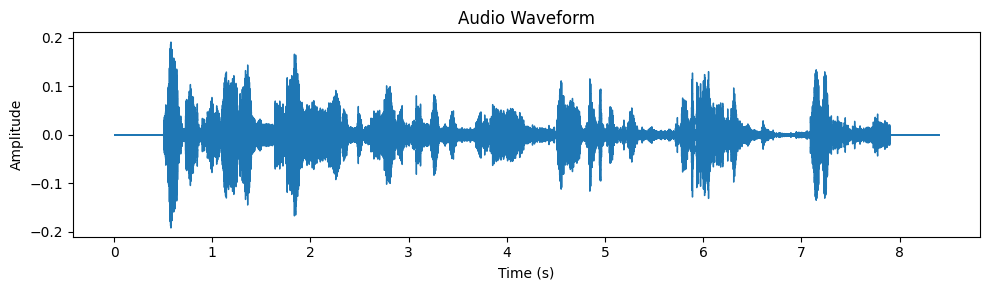

In [ ]:
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## 6. Word-Level Force Alignment with Wav2Vec

Now, let's perform word-level force alignment using the wav2vec model.

In [ ]:
# Load pre-trained model and processor for Arabic
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-arabic"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

# Load the audio with torchaudio for processing
waveform, sample_rate = torchaudio.load(audio_path)
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Resample (wav2vec2 expects 16kHz)
if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
    waveform = resampler(waveform)
    sample_rate = 16000

# Convert audio to features
input_values = processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt").input_values

# Get the CTC probabilities (it gives series of characters predictions)
with torch.no_grad():
    logits = model(input_values).logits

# Get the probability matrix
probs = torch.nn.functional.softmax(logits, dim=-1)
probs = probs.squeeze().detach().cpu()
print(probs.shape)

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


torch.Size([419, 51])


**`probs.shape`** returns a shape of **`(419, 51)`**.
This means there are 419 frames, where each frame represents 20 milliseconds of audio.

For every 20 ms segment, the model outputs a probability vector of size 51, corresponding to the likelihoods of 51 possible character predictions — such as ألف، باء، تاء and so on.

To understand which index corresponds to which character, we retrieve the vocabulary using `processor.tokenizer.get_vocab()`.

This allows us to interpret the output probabilities by mapping each index in the vector to its corresponding Arabic character or special symbol.

In [ ]:
# Get the character mapping
vocab = processor.tokenizer.get_vocab()
id_to_char = {v: k for k, v in vocab.items()}
print(id_to_char)

{0: '<pad>', 1: '<s>', 2: '</s>', 3: '<unk>', 4: '|', 5: '-', 6: 'ء', 7: 'آ', 8: 'أ', 9: 'ؤ', 10: 'إ', 11: 'ئ', 12: 'ا', 13: 'ب', 14: 'ة', 15: 'ت', 16: 'ث', 17: 'ج', 18: 'ح', 19: 'خ', 20: 'د', 21: 'ذ', 22: 'ر', 23: 'ز', 24: 'س', 25: 'ش', 26: 'ص', 27: 'ض', 28: 'ط', 29: 'ظ', 30: 'ع', 31: 'غ', 32: 'ـ', 33: 'ف', 34: 'ق', 35: 'ك', 36: 'ل', 37: 'م', 38: 'ن', 39: 'ه', 40: 'و', 41: 'ى', 42: 'ي', 43: 'ً', 44: 'ٌ', 45: 'ٍ', 46: 'َ', 47: 'ُ', 48: 'ِ', 49: 'ّ', 50: 'ْ'}


Let's now use the probability matrix to get the alignmnet for each characters.

## 7. Alignment Probability -- Trellis

From the emission matrix, we generate the **trellis**, which represents the probability accumulations of transcript labels at each time frame.

The trellis is a 2D matrix with  
- **time axis** indexed by `t`  
- **label axis** indexed by `j`, representing the transcript labels  


In [ ]:
def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],)
    return trellis

# let's tokenize our sentence:
sentence="هذا الشارع سوي لممارسه رياضه الركض يوميا و لم التقي باي شخص علي الاطلاق"
tokens = processor.tokenizer(sentence, add_special_tokens=False).input_ids

# let's get trellis
trellis = get_trellis(probs, tokens)

## 8. Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the elements with high probability. => this is called backtracking



In [ ]:
from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float

## Based ion Viterbi optimization
def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, probs, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=2.7182013988494873)
Point(token_index=0, time_index=1, score=2.718154191970825)
Point(token_index=0, time_index=2, score=2.7181615829467773)
Point(token_index=0, time_index=3, score=2.7181756496429443)
Point(token_index=0, time_index=4, score=2.7182092666625977)
Point(token_index=0, time_index=5, score=2.718273639678955)
Point(token_index=0, time_index=6, score=2.7182457447052)
Point(token_index=0, time_index=7, score=2.7182490825653076)
Point(token_index=0, time_index=8, score=2.7182791233062744)
Point(token_index=0, time_index=9, score=2.71828031539917)
Point(token_index=0, time_index=10, score=2.718280553817749)
Point(token_index=0, time_index=11, score=2.718280553817749)
Point(token_index=0, time_index=12, score=2.71828031539917)
Point(token_index=0, time_index=13, score=2.718276262283325)
Point(token_index=0, time_index=14, score=2.7182457447052)
Point(token_index=0, time_index=15, score=2.718266248703003)
Point(token_index=0, time_index=16

## 9. Segment the path

Now this path contains repetations for the same labels you can notice (token_index) as, so let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average probability for the merged segments.

In [ ]:
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)


ه	(2.67): [    0,    36)
ذ	(2.72): [   36,    39)
ا	(1.85): [   39,    43)
 	(1.91): [   43,    47)
ا	(2.32): [   47,    49)
ل	(2.72): [   49,    53)
ش	(2.72): [   53,    59)
ا	(2.72): [   59,    63)
ر	(2.44): [   63,    69)
ع	(2.05): [   69,    72)
 	(1.78): [   72,    80)
س	(2.72): [   80,    87)
و	(2.29): [   87,    91)
ي	(1.00): [   91,    92)
 	(2.68): [   92,    96)
ل	(2.16): [   96,   103)
م	(2.72): [  103,   108)
م	(2.40): [  108,   113)
ا	(2.72): [  113,   116)
ر	(2.43): [  116,   122)
س	(2.43): [  122,   128)
ه	(1.94): [  128,   130)
 	(1.70): [  130,   132)
ر	(2.67): [  132,   136)
ي	(2.72): [  136,   140)
ا	(2.49): [  140,   144)
ض	(2.43): [  144,   150)
ه	(1.95): [  150,   153)
 	(2.58): [  153,   156)
ا	(1.59): [  156,   159)
ل	(2.72): [  159,   161)
ر	(2.66): [  161,   169)
ك	(2.48): [  169,   176)
ض	(2.21): [  176,   181)
 	(2.15): [  181,   185)
ي	(2.62): [  185,   190)
و	(2.72): [  190,   194)
م	(2.72): [  194,   200)
ي	(2.55): [  200,   204)
ا	(2.20): [  204,   222)


## 10. Merge the segments into words

Now let’s merge the words.
Then, finally, we segment the original audio into segmented audio and listen to them to see if the segmentation is correct.

In [ ]:
# Merge words
def merge_words(segments, separator=" "):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

هذا	(2.59): [    0,    43)
الشارع	(2.54): [   47,    72)
سوي	(2.43): [   80,    92)
لممارسه	(2.41): [   96,   130)
رياضه	(2.47): [  132,   153)
الركض	(2.40): [  156,   181)
يوميا	(2.44): [  185,   222)
و	(1.90): [  226,   228)
لم	(2.50): [  231,   239)
التقي	(2.58): [  241,   283)
باي	(2.61): [  288,   306)
شخص	(2.47): [  313,   351)
علي	(2.36): [  356,   364)
الاطلاق	(2.52): [  365,   419)


In [ ]:
import IPython

def display_segment(i):
    ratio = waveform.size(1) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / 16000:.3f} - {x1 / 16000:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=16000)

In [ ]:
display_segment(0)

هذا (2.59): 0.000 - 0.862 sec


In [ ]:
display_segment(1)

الشارع (2.54): 0.942 - 1.443 sec


In [ ]:
display_segment(2)

سوي (2.43): 1.604 - 1.844 sec


In [ ]:
display_segment(10)

باي (2.61): 5.774 - 6.135 sec


## 11. Conclusion

In this tutorial, you've learned how to:

1. Understand what force alignment is and why it's useful
2. Use wav2vec to perform word-level alignment on Arabic audio
3. Create an interactive visualization where you can click on words to hear them

This technique can be applied to any language supported by wav2vec models and is useful for many applications including subtitling, language learning, and audio editing.